In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import os
import seaborn as sns
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import statsmodels.stats.multitest as ss
from scipy import stats
from matplotlib import gridspec as gs

In [5]:
len(EukMAGDF.index)

985

In [6]:
len(EukMAGDF_HQ.index)

484

In [4]:
#Read in MAG data
mag_info=pd.read_csv(os.path.join("..","input","eukulele_mmseqs_joined_tax.csv")).\
        merge(pd.read_csv(os.path.join("..","input","eukulele_mmseqs_joined_tax_sarahgroups.csv")),how="left")

mag_info["Genome"]=mag_info["new_mag_name"]
translation_dict = pd.read_csv(os.path.join("..","input",'renamed-eukaryotic-mags.tsv'), sep='\t')

busco_completeness = pd.read_csv(os.path.join("..","input","EUK_BUSCO_CC.csv")).\
    merge(translation_dict,left_on="Unnamed: 0",right_on="old_mag_name")
mag_info = mag_info.merge(busco_completeness,left_on="new_mag_name",right_on="new_mag_name")
#mag_info=mag_info[mag_info.Completeness>=30]
#HQ_Mags = HQ_Mags.merge(busco_completeness,left_on="new_mag_name",right_on="new_mag_name")
#HQ_Mags[HQ_Mags.Completeness>=0]
mag_info=mag_info.merge(pd.read_csv(os.path.join("..","input","taxonomy-colors.csv")),
                                                           left_on="sarah_groups",
                                                           right_on="tax_group")

EukMAGDF = pd.read_csv(os.path.join("..","input","TableS2_EukaryoticMAG.csv"), index_col=0)
translation_dict = pd.read_csv(os.path.join("..","input",'renamed-eukaryotic-mags.tsv'),
                               sep='\t', index_col=0).to_dict()['new_mag_name']
translation_dict_r = pd.read_csv(os.path.join("..","input",'renamed-eukaryotic-mags.tsv'),
                                 sep='\t', index_col=1).to_dict()['old_mag_name']
mag_info.index = mag_info["new_mag_name"]
#HQ_Mags.index = HQ_Mags.index.map(translation_dict)
EukMAGDF['total_length_Mb'] = EukMAGDF.total_length/10**6

EukMAGDF_HQ = EukMAGDF.merge(mag_info[mag_info.Completeness>=30], left_index=True, right_index=True)
EukMAGDF = EukMAGDF.merge(mag_info, left_index=True, right_index=True)
tax_colors=pd.read_csv(os.path.join("..","input","taxonomy-colors.csv"))

cdict=dict(zip(tax_colors.tax_group,tax_colors.color))
cdict["SAR"]="#6EAA93"

#Read in pangea data
pangea = pd.read_csv('../input/TARA_sample_enviro.tab', sep ='\t', header=2508, index_col=0)
ena_table = pd.read_csv('../input/PRJEB4352_metaG.txt', sep='\t')
ena_data = ena_table.merge(pangea, left_on='sample_alias', right_index=True) 
ena_data = ena_data.set_index('run_accession')
errdf = pd.read_csv('../input/SampleList_2020_metaG.txt', sep='\t')
errnewdf = pd.DataFrame(columns=errdf.columns)
for i in errdf.index:
    E = errdf.loc[i, 'ERR_list'].split(', ')
    for e in E:
        if e in errnewdf.index:
            pass
        else:
            errnewdf.loc[e]=errdf.loc[i]
errnewdf['depth'] = errnewdf.Depth_sizefrac.str.split('-').str[0]
errnewdf['sf'] = errnewdf.Depth_sizefrac.str.split('-').str[1:].str.join('-')

#read in metagenomic abundance
tpm_df = pd.read_csv(os.path.join("..","input","MAG_tpm_new_approach.csv"), index_col=0)
#tpm_df2 = tpm_df.copy()
#tpm_df.index = tpm_df.index.map(translation_dict)
tpm_df.index=tpm_df.Genome
tpm_df=tpm_df.drop("Genome",axis=1)
tpm_df = tpm_df.merge(EukMAGDF_HQ,left_index=True,right_index=True,how="inner")




In [17]:
cdict

{'Chlorophyta': '#DFF2A6',
 'Bacillariophyta': '#1D8C8A',
 'Haptophyta': '#EB9E7A',
 'Sar': '#6EAA93',
 'SAR': '#6EAA93',
 'Fungi': '#821C4A',
 'Eukaryota': '#CDCBCC',
 'Alveolata': '#62CBB2',
 'Amoebozoa': '#E66B92',
 'Apusozoa': '#9A6ACD',
 'Choanozoa': '#FCDCFF',
 'Cryptophyta': '#C6BE53',
 'Dinoflagellata': '#18AB7B',
 'Metazoa': '#61186D',
 'Ochrophyta': '#ACDCC8'}

In [7]:
with open('cdict_colors.txt', 'w') as f:
    for c in cdict:
        f.write('\t'.join([c,cdict[c]]))
        f.write('\n')

In [8]:
def draw_pie(dist, 
             xpos, 
             ypos, 
             size, cartopy=True,
             ax=None, colors=['blue', 'red'], alpha=0.8):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))

    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()
    if cartopy:
        for r1, r2, c in zip(pie[:-1], pie[1:], colors):
            angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
            x = [0] + np.cos(angles).tolist()
            y = [0] + np.sin(angles).tolist()

            xy = np.column_stack([x, y])

            ax.scatter([xpos], [ypos], marker=xy, s=size, transform=ccrs.PlateCarree(), color=c, alpha=alpha)
    else:
        for r1, r2 in zip(pie[:-1], pie[1:]):
            angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
            x = [0] + np.cos(angles).tolist()
            y = [0] + np.sin(angles).tolist()

            xy = np.column_stack([x, y])

            ax.scatter([xpos], [ypos], marker=xy, s=size,)

    return ax
def plot_maps_overlay_sf(df, scale = 10e-4, ax=None, depth = 'SRF'):
    sf = ['0.8-5.00','5-20.00', '20-180.00','180-2000.00', ]
    fig = plt.figure(figsize=(18, 18))
    gs = fig.add_gridspec(1, 4)

    for i, s in enumerate(sf):
        sdf = df[(df['sf']==s) & (df['depth']==depth)]
        ax = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND, color = 'gray')
        for i in sdf.index:
            draw_pie([sdf.loc[i,'Heterotroph'],sdf.loc[i,'Phototroph']], 
                     xpos =sdf.loc[i,'Longitude'], ypos=sdf.loc[i,'Latitude'],
                     size=sdf.loc[i,['Heterotroph', 'Phototroph']].sum()*scale, cartopy=True, ax=ax, 
                     colors=[het_col['Heterotroph'], het_col['Phototroph']])
        ax.set_title(s)
    plt.show()

def calc_rho_pval(summed_count_df, method = 'Bonferroni'):
    out_rho = pd.DataFrame(columns= summed_count_df.columns,index= summed_count_df.columns, )
    out_pval = pd.DataFrame(columns= summed_count_df.columns,index= summed_count_df.columns, )

    for j in summed_count_df.columns:
        for i in summed_count_df.columns:
            dd = summed_count_df[[i,j]].dropna()
            rho, pval =stats.spearmanr(dd[i], dd[j])
            if i==j:
                out_rho.loc[i, j] = 1
                out_pval.loc[i, j] = 0
            else:
                out_rho.loc[i, j] = rho;
                out_pval.loc[i,j] = pval;
#         out_rho.columns = test_corr_pval.columns
#         out_rho.index = test_corr_pval.columns
#         out_pval.columns = test_corr_pval.columns
#         out_pval.index = test_corr_pval.columns
#         out_bonfe=pd.DataFrame(columns = test_corr_pval.columns, index = test_corr_pval.columns)
#         out_bool=pd.DataFrame(columns = test_corr_pval.columns, index = test_corr_pval.columns)

#         for column in out_pval.columns:
#             a, b,c,d = ss.multipletests(out_pval[column], method='bonferroni')
#             out_bonfe[column] = b
#             out_bool[column] = a
    out_bonfe = pd.DataFrame(out_pval.unstack())
    a, b ,c, d = ss.multipletests(pd.DataFrame(out_pval.unstack())[0], method=method)
    out_bonfe[0]=b
    out_bonfe = out_bonfe.reset_index().pivot(columns='level_0', index='level_1', values=0)
    return(out_rho, out_pval, out_bonfe)

def cluster_map_bonfe(rhodf, pvaldf, figname='figures/cluster.pdf',
                      cutoff=0.05, col_colors=None, row_colors=None, symbol='*', vmin=-1, vmax=1, xticklabel=1):
    cluster = sns.clustermap(rhodf.fillna(0), col_colors=col_colors, row_colors=row_colors,yticklabels=1, 
                         metric='braycurtis',
                 vmin=vmin, vmax=vmax, cmap=sns.color_palette("icefire", as_cmap=True),
                  xticklabels =1,)
    posx_dict={}
    for i in np.array(cluster.ax_heatmap.get_xticklabels()):
        posx_dict[i.get_text()] = i.get_position()[0]
    posy_dict={}
    for i in np.array(cluster.ax_heatmap.get_yticklabels()):
        posy_dict[i.get_text()] = i.get_position()[1]

    sig_map = pvaldf<cutoff
    sig_map.index = sig_map.index.map(posy_dict)
    sig_map.columns = sig_map.columns.map(posx_dict)
    x =[]
    y = []
    for i in sig_map.index:
        for c in sig_map.columns:
            if sig_map.loc[i,c]==True:
                x.append(c)
                y.append(i)
    ax = cluster.ax_heatmap
    ax.scatter(x,y, marker=symbol, color='white', s=2)

    plt.savefig(figname)

# All Eukaryotic MAGs
## No BUSCO cutoff 

In [45]:
order = ['Eukaryota','Metazoa','Apusozoa','Choanozoa',
         'Amoebozoa','Fungi','SAR', 'Dinoflagellata','Ochrophyta',"Bacillariophyta",
         'Chlorophyta', 'Cryptophyta','Haptophyta',"Alveolata"]

In [9]:
EukMAGDF_HQ

,eukulele_taxonomy,mmseqs_taxonomy,groups,total_length,total_num_contigs,total_length_5kb,total_length_10kb,total_length_50kb,GC_percent,N50,...,depth_y,size_fraction_y,sarah_groups,Genome,Unnamed: 0_y,Completeness,Contamination,old_mag_name,tax_group,color
TOPAZ_IOD1_E001,Eukaryota;Hacrobia;Cryptophyta;Cryptophyceae;C...,Eukaryota;-;-;-;Cryptophyceae;-;Pyrenomonadale...,Cryptophyta,37074820,8377,15520088,2726308,0,58.27,4531,...,DCM,0-8-5-00,Cryptophyta,TOPAZ_IOD1_E001,IO-all-DCM-0-8-5-00_bin-104,57.254902,2.745098,IO-all-DCM-0-8-5-00_bin-104,Cryptophyta,#C6BE53
TOPAZ_IOD1_E003,Eukaryota;Hacrobia;Haptophyta;Prymnesiophyceae...,Eukaryota;-;Prymnesiophyceae;Haptista;Haptophy...,Haptophyta,30740252,7112,12314358,2329232,0,62.86,4424,...,DCM,0-8-5-00,Haptophyta,TOPAZ_IOD1_E003,IO-all-DCM-0-8-5-00_bin-111,49.411765,0.392157,IO-all-DCM-0-8-5-00_bin-111,Haptophyta,#EB9E7A
TOPAZ_IOD1_E004,Eukaryota;Hacrobia;Haptophyta;Prymnesiophyceae...,Eukaryota;-;Prymnesiophyceae;Haptista;Haptophy...,Haptophyta,39191221,9102,15279501,2168595,0,62.08,4404,...,DCM,0-8-5-00,Haptophyta,TOPAZ_IOD1_E004,IO-all-DCM-0-8-5-00_bin-12,50.980392,0.392157,IO-all-DCM-0-8-5-00_bin-12,Haptophyta,#EB9E7A
TOPAZ_IOD1_E005,Eukaryota;Archaeplastida;Chlorophyta;Mamiellop...,Eukaryota;Viridiplantae;-;Chlorophyta;Mamiello...,Chlorophyta,17055374,1415,15579731,12443612,1136508,66.20,17298,...,DCM,0-8-5-00,Chlorophyta,TOPAZ_IOD1_E005,IO-all-DCM-0-8-5-00_bin-120,74.901961,0.392157,IO-all-DCM-0-8-5-00_bin-120,Chlorophyta,#DFF2A6
TOPAZ_IOD1_E008,Eukaryota;-;-;-;-;-;-;-,Eukaryota;-;Sar;-;-;-;-;-;-,SAR,25519293,5508,11988952,2613370,0,33.14,4794,...,DCM,0-8-5-00,SAR,TOPAZ_IOD1_E008,IO-all-DCM-0-8-5-00_bin-157,65.490196,1.176471,IO-all-DCM-0-8-5-00_bin-157,SAR,#6EAA93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TOPAZ_SPS2_E012,Eukaryota;Archaeplastida;Chlorophyta;Chloropic...,Eukaryota;Viridiplantae;-;Chlorophyta;-;-;-;-;-,Chlorophyta,15907200,2277,12070333,6352917,0,49.31,8570,...,SRF,5/20/00,Chlorophyta,TOPAZ_SPS2_E012,SPO-all-SRF-5-20-00_bin-108,81.960784,0.000000,SPO-all-SRF-5-20-00_bin-108,Chlorophyta,#DFF2A6
TOPAZ_SPS2_E014,Eukaryota;Archaeplastida;Chlorophyta;-;-;-;-;-,Eukaryota;Viridiplantae;-;Chlorophyta;-;-;-;Py...,Chlorophyta,14224257,1967,11098354,6045459,0,60.84,8816,...,SRF,5/20/00,Chlorophyta,TOPAZ_SPS2_E014,SPO-all-SRF-5-20-00_bin-111,84.705882,0.000000,SPO-all-SRF-5-20-00_bin-111,Chlorophyta,#DFF2A6
TOPAZ_SPS2_E017,Eukaryota;Archaeplastida;Chlorophyta;Chloropic...,Eukaryota;Viridiplantae;-;Chlorophyta;-;-;-;-;-,Chlorophyta,9413100,2242,3345635,449150,0,48.29,4273,...,SRF,5/20/00,Chlorophyta,TOPAZ_SPS2_E017,SPO-all-SRF-5-20-00_bin-120,49.411765,0.392157,SPO-all-SRF-5-20-00_bin-120,Chlorophyta,#DFF2A6
TOPAZ_SPS2_E018,Eukaryota;Archaeplastida;Chlorophyta;Chloropic...,Eukaryota;Viridiplantae;-;Chlorophyta;-;-;-;-;-,Chlorophyta,14114129,2035,10639085,5753751,105153,62.07,8377,...,SRF,5/20/00,Chlorophyta,TOPAZ_SPS2_E018,SPO-all-SRF-5-20-00_bin-13,81.176471,0.392157,SPO-all-SRF-5-20-00_bin-13,Chlorophyta,#DFF2A6


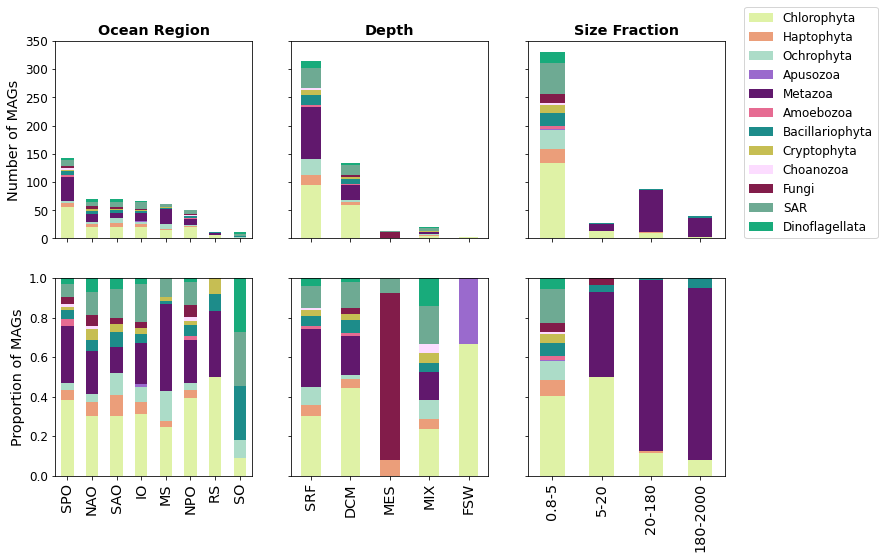

In [37]:
order = ['Metazoa','Apusozoa','Choanozoa',
         'Amoebozoa','Fungi','SAR', 'Dinoflagellata','Ochrophyta',"Bacillariophyta",
         'Chlorophyta', 'Cryptophyta','Haptophyta',"Eukaryota","Alveolata"]


fig, ax = plt.subplots(2,3, figsize = [12,8])
ax=ax.flatten()
depth = pd.DataFrame(EukMAGDF_HQ.groupby(['depth_x', 'sarah_groups']).count()['color']).reset_index()
depth = depth.pivot(index='sarah_groups', columns='depth_x', values='color').fillna(0)
dorder=['SRF',  'DCM', 'MES', 'MIX', 'FSW']
depth.T.loc[dorder,list(set(order).intersection(set(depth.T.columns)))].plot(kind='bar', stacked=True, color=cdict,ax=ax[1], legend=None)
dn = (depth/depth.sum())
dn.T.loc[dorder,list(set(order).intersection(set(dn.T.columns)))].plot(kind='bar', stacked=True, color=cdict,ax=ax[4], legend=None)
# ocean region
region = pd.DataFrame(EukMAGDF_HQ.groupby(['ocean_region', 'sarah_groups']).count()['color']).reset_index()
region = region.pivot(index='sarah_groups', columns='ocean_region', values='color').fillna(0)
rorder = region.sum().sort_values(ascending=False).index
rn = (region/region.sum())
rn.T.loc[rorder, list(set(order).intersection(set(rn.T.columns)))].plot(kind='bar', stacked=True, color=cdict,ax=ax[3], legend=None)

region.T.loc[rorder,list(set(order).intersection(set(region.T.columns)))].plot(kind='bar', stacked=True, color=cdict, legend=None, ax=ax[0])
#size fraction
sf = pd.DataFrame(EukMAGDF_HQ.groupby(['size_fraction_x', 'sarah_groups']).count()['color']).reset_index()
sf = sf.pivot(index='sarah_groups', columns='size_fraction_x', values='color').fillna(0)
sforder = ['0.8-5', '5-20', '20-180','180-2000', ]
sf.T.loc[sforder,list(set(order).intersection(set(sf.T.columns)))].plot(kind='bar', stacked=True, color=cdict, legend=[1,1], ax=ax[2],)
sn = (sf/sf.sum())
sn.T.loc[sforder, list(set(order).intersection(set(sn.T.columns)))].plot(kind='bar', stacked=True, color=cdict,ax=ax[5], legend=None)

handles,labels = ax[2].get_legend_handles_labels()
ldict= dict(zip(labels, handles))
olabels = []
ohandles= []

for l in list(set(order).intersection(set(sn.T.columns))):
    olabels.append(l)
    ohandles.append(ldict[l])

ax[2].legend(ohandles, olabels, loc=[1.1 ,0], fontsize='large')
labels = ['Ocean Region', 'Depth', 'Size Fraction']
for a,l in zip(ax[0:3], labels):
    a.set_ylim(0,350)
    a.set_xlabel('')
    a.set_xticklabels('')
    a.set_title(l, fontweight='bold', size='x-large')
for a in ax[3:]:
    a.set_ylim(0,1)
for i in (1,2,4,5):
    ax[i].set_yticklabels('')
for a in ax:
    a.tick_params(axis='y', 
                labelsize='large')
    a.tick_params(axis='x', 
                labelsize='x-large')
    a.set_xlabel('')
ax[0].set_ylabel('Number of MAGs',fontsize='x-large')
ax[3].set_ylabel('Proportion of MAGs',fontsize='x-large')


fig.savefig('../figures/HQ_MAG_distributions.pdf', bbox_inches='tight')
fig.savefig('../figures/HQ_MAG_distributions.png', bbox_inches='tight')

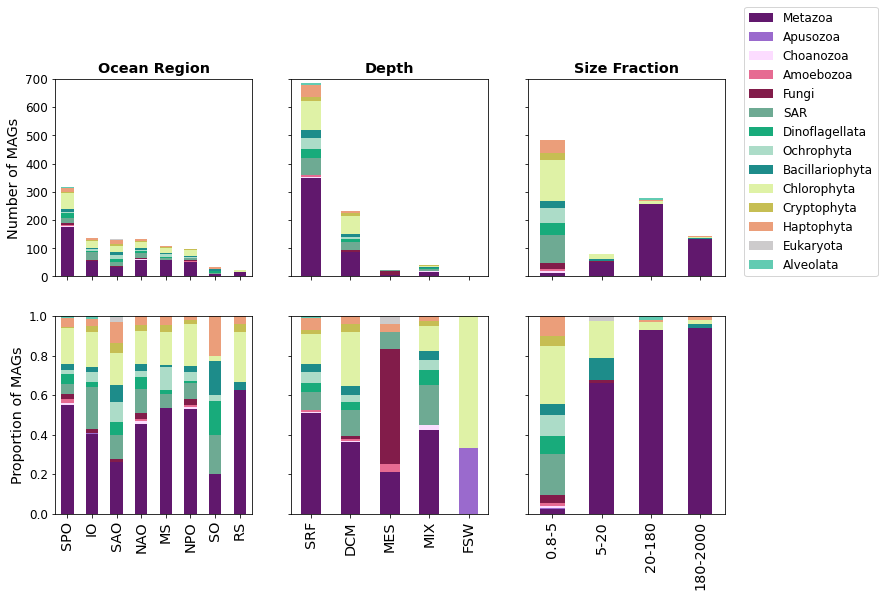

In [36]:


fig, ax = plt.subplots(2,3, figsize = [12,8])
ax=ax.flatten()
depth = pd.DataFrame(EukMAGDF.groupby(['depth_x', 'sarah_groups']).count()['color']).reset_index()
depth = depth.pivot(index='sarah_groups', columns='depth_x', values='color').fillna(0)
dorder=['SRF',  'DCM', 'MES', 'MIX', 'FSW']
depth.T.loc[dorder,order].plot(kind='bar', stacked=True, color=cdict,ax=ax[1], legend=None)
dn = (depth/depth.sum())
dn.T.loc[dorder,order].plot(kind='bar', stacked=True, color=cdict,ax=ax[4], legend=None)
# ocean region
region = pd.DataFrame(EukMAGDF.groupby(['ocean_region', 'sarah_groups']).count()['color']).reset_index()
region = region.pivot(index='sarah_groups', columns='ocean_region', values='color').fillna(0)
rorder = region.sum().sort_values(ascending=False).index
rn = (region/region.sum())
rn.T.loc[rorder, order].plot(kind='bar', stacked=True, color=cdict,ax=ax[3], legend=None)

region.T.loc[rorder,order].plot(kind='bar', stacked=True, color=cdict, legend=None, ax=ax[0])
#size fraction
sf = pd.DataFrame(EukMAGDF.groupby(['size_fraction_x', 'sarah_groups']).count()['color']).reset_index()
sf = sf.pivot(index='sarah_groups', columns='size_fraction_x', values='color').fillna(0)
sforder = ['0.8-5', '5-20', '20-180','180-2000', ]
sf.T.loc[sforder,order].plot(kind='bar', stacked=True, color=cdict, legend=[1,1], ax=ax[2],)
sn = (sf/sf.sum())
sn.T.loc[sforder, order].plot(kind='bar', stacked=True, color=cdict,ax=ax[5], legend=None)

handles,labels = ax[2].get_legend_handles_labels()
ldict= dict(zip(labels, handles))
olabels = []
ohandles= []

for l in order:
    olabels.append(l)
    ohandles.append(ldict[l])

ax[2].legend(ohandles, olabels, loc=[1.1 ,0], fontsize='large')
labels = ['Ocean Region', 'Depth', 'Size Fraction']
for a,l in zip(ax[0:3], labels):
    a.set_ylim(0,700)
    a.set_xlabel('')
    a.set_xticklabels('')
    a.set_title(l, fontweight='bold', size='x-large')
for a in ax[3:]:
    a.set_ylim(0,1)
for i in (1,2,4,5):
    ax[i].set_yticklabels('')
for a in ax:
    a.tick_params(axis='y', 
                labelsize='large')
    a.tick_params(axis='x', 
                labelsize='x-large')
    a.set_xlabel('')
ax[0].set_ylabel('Number of MAGs',fontsize='x-large')
ax[3].set_ylabel('Proportion of MAGs',fontsize='x-large')


fig.savefig('../figures/ALL_MAG_distributions.pdf', bbox_inches='tight')
fig.savefig('../figures/ALL_MAG_distributions.png', bbox_inches='tight')

In [11]:
EukMAGDF

,eukulele_taxonomy,mmseqs_taxonomy,groups,total_length,total_num_contigs,total_length_5kb,total_length_10kb,total_length_50kb,GC_percent,N50,...,depth_y,size_fraction_y,sarah_groups,Genome,Unnamed: 0_y,Completeness,Contamination,old_mag_name,tax_group,color
TOPAZ_IOD1_E001,Eukaryota;Hacrobia;Cryptophyta;Cryptophyceae;C...,Eukaryota;-;-;-;Cryptophyceae;-;Pyrenomonadale...,Cryptophyta,37074820,8377,15520088,2726308,0,58.27,4531,...,DCM,0-8-5-00,Cryptophyta,TOPAZ_IOD1_E001,IO-all-DCM-0-8-5-00_bin-104,57.254902,2.745098,IO-all-DCM-0-8-5-00_bin-104,Cryptophyta,#C6BE53
TOPAZ_IOD1_E002,Eukaryota;-;-;-;-;-;-;-,Eukaryota;-;Sar;-;-;-;-;-;-,SAR,2801896,851,188909,0,0,44.45,3208,...,DCM,0-8-5-00,SAR,TOPAZ_IOD1_E002,IO-all-DCM-0-8-5-00_bin-107,13.725490,0.000000,IO-all-DCM-0-8-5-00_bin-107,SAR,#6EAA93
TOPAZ_IOD1_E003,Eukaryota;Hacrobia;Haptophyta;Prymnesiophyceae...,Eukaryota;-;Prymnesiophyceae;Haptista;Haptophy...,Haptophyta,30740252,7112,12314358,2329232,0,62.86,4424,...,DCM,0-8-5-00,Haptophyta,TOPAZ_IOD1_E003,IO-all-DCM-0-8-5-00_bin-111,49.411765,0.392157,IO-all-DCM-0-8-5-00_bin-111,Haptophyta,#EB9E7A
TOPAZ_IOD1_E004,Eukaryota;Hacrobia;Haptophyta;Prymnesiophyceae...,Eukaryota;-;Prymnesiophyceae;Haptista;Haptophy...,Haptophyta,39191221,9102,15279501,2168595,0,62.08,4404,...,DCM,0-8-5-00,Haptophyta,TOPAZ_IOD1_E004,IO-all-DCM-0-8-5-00_bin-12,50.980392,0.392157,IO-all-DCM-0-8-5-00_bin-12,Haptophyta,#EB9E7A
TOPAZ_IOD1_E005,Eukaryota;Archaeplastida;Chlorophyta;Mamiellop...,Eukaryota;Viridiplantae;-;Chlorophyta;Mamiello...,Chlorophyta,17055374,1415,15579731,12443612,1136508,66.20,17298,...,DCM,0-8-5-00,Chlorophyta,TOPAZ_IOD1_E005,IO-all-DCM-0-8-5-00_bin-120,74.901961,0.392157,IO-all-DCM-0-8-5-00_bin-120,Chlorophyta,#DFF2A6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TOPAZ_SPS2_E022,Eukaryota;Stramenopiles;Ochrophyta;Bacillariop...,Eukaryota;-;Sar;Bacillariophyta;Coscinodiscoph...,Ochrophyta,2727571,776,468206,141060,0,33.36,3336,...,SRF,5/20/00,Bacillariophyta,TOPAZ_SPS2_E022,SPO-all-SRF-5-20-00_bin-20,0.784314,0.000000,SPO-all-SRF-5-20-00_bin-20,Bacillariophyta,#1D8C8A
TOPAZ_SPS2_E023,Eukaryota;Metazoa;-;-;-;-;-;-,Eukaryota;Metazoa;Opisthokonta;Arthropoda;-;-;...,Metazoa,4663657,1284,1007863,25306,0,35.17,3539,...,SRF,5/20/00,Metazoa,TOPAZ_SPS2_E023,SPO-all-SRF-5-20-00_bin-223,0.392157,0.000000,SPO-all-SRF-5-20-00_bin-223,Metazoa,#61186D
TOPAZ_SPS2_E024,Eukaryota;Archaeplastida;Chlorophyta;Chloropic...,Eukaryota;Viridiplantae;-;Chlorophyta;-;-;-;-;-,Chlorophyta,13957152,2682,8130431,2420844,0,48.06,5594,...,SRF,5/20/00,Chlorophyta,TOPAZ_SPS2_E024,SPO-all-SRF-5-20-00_bin-55,66.666667,0.784314,SPO-all-SRF-5-20-00_bin-55,Chlorophyta,#DFF2A6
TOPAZ_SPS2_E025,Eukaryota;Metazoa;-;-;-;-;-;-,Eukaryota;Metazoa;Opisthokonta;-;-;-;-;-;-,Metazoa,6686567,1796,1645262,25585,0,41.01,3612,...,SRF,5/20/00,Metazoa,TOPAZ_SPS2_E025,SPO-all-SRF-5-20-00_bin-57,0.000000,0.000000,SPO-all-SRF-5-20-00_bin-57,Metazoa,#61186D


In [30]:
EukMAGDF.groupby('sarah_groups').count()['eukulele_taxonomy']

sarah_groups
Alveolata            6
Amoebozoa            8
Apusozoa             1
Bacillariophyta     41
Chlorophyta        171
Choanozoa            6
Cryptophyta         24
Dinoflagellata      44
Eukaryota            3
Fungi               20
Haptophyta          54
Metazoa            456
Ochrophyta          50
SAR                101
Name: eukulele_taxonomy, dtype: int64

<AxesSubplot:xlabel='sarah_groups'>

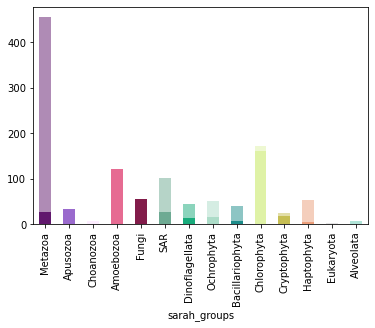

In [54]:
EukMAGDF_HQ.groupby('sarah_groups').count()['eukulele_taxonomy'][list(set(order).intersection(set(EukMAGDF_HQ.sarah_groups)))].plot(kind='bar', color = [cdict[i] for i in order])

EukMAGDF.groupby('sarah_groups').count()['eukulele_taxonomy'][order].plot(kind='bar', color = [cdict[i] for i in order], alpha=0.5)

/tmp/ipykernel_272771/2740229023.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(0,401,100), fontsize='large');


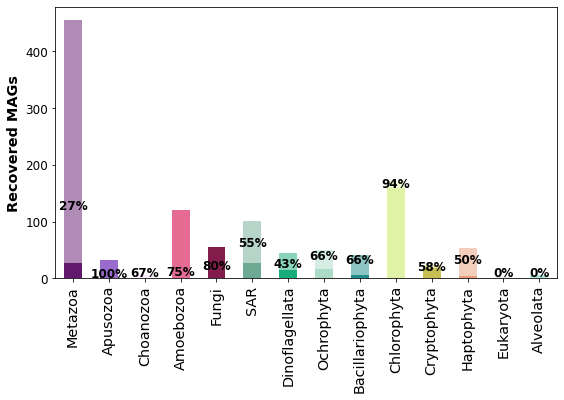

In [57]:
fig, ax = plt.subplots(1,figsize = (9,5))
EukMAGDF_HQ.groupby('sarah_groups').count()['eukulele_taxonomy'][list(set(order).intersection(set(EukMAGDF_HQ.sarah_groups)))].plot(kind='bar', color = [cdict[i] for i in order])
EukMAGDF.groupby('sarah_groups').count()['eukulele_taxonomy'][order].plot(kind='bar', color = [cdict[i] for i in order], alpha=0.5)

percentage = EukMAGDF_HQ.groupby('sarah_groups').count()['eukulele_taxonomy']/EukMAGDF.groupby('sarah_groups').count()['N50']

for i,n in enumerate(order):
    #ax.text(i, EukMAGDF_HQ.groupby('sarah_groups').count().loc[n,'eukulele_taxonomy']+ 5, "{:.0%}".format(percentage[n]), ha='center', 
    #           fontweight='bold', fontsize='large')
    if n in set(EukMAGDF_HQ.sarah_groups):
        ax.text(i, EukMAGDF_HQ.groupby('sarah_groups').count().loc[n,'eukulele_taxonomy'], "{:.0%}".format(percentage[n]), ha='center', 
               fontweight='bold', fontsize='large')
    else:
        ax.text(i, 3, "{:.0%}".format(0), ha='center', 
               fontweight='bold', fontsize='large')
        
ax.set_xticklabels(order, fontsize='x-large')
ax.set_xlabel('')
ax.set_ylabel('Recovered MAGs', fontsize='x-large', fontweight='bold')
ax.set_yticklabels(range(0,401,100), fontsize='large');
fig.savefig('../figures/MAGS_recovered.pdf', bbox_inches='tight')
fig.savefig('../figures/MAGS_recovered.png', bbox_inches='tight')

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboxinches" which is no longer supported as of 3.3 and will become an error two minor releases later
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboxinches" which is no longer supported as of 3.3 and will become an error two minor releases later


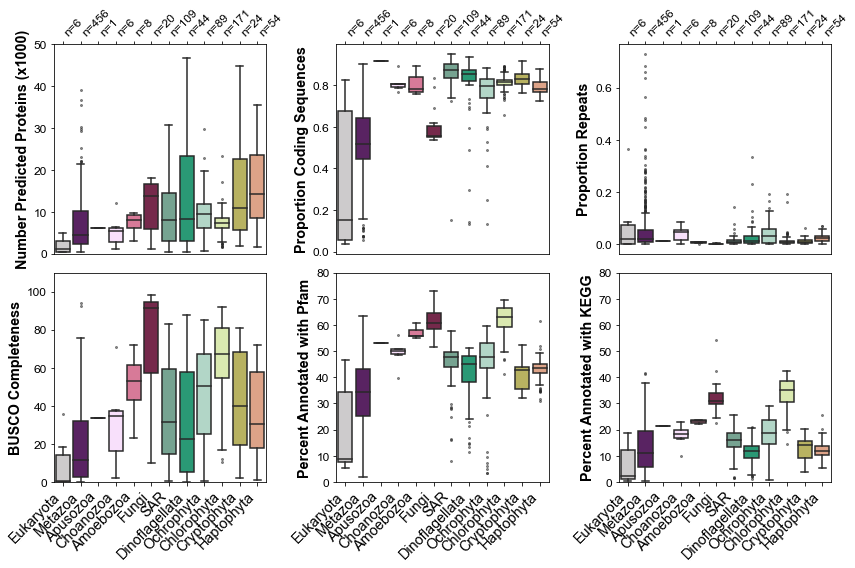

In [7]:

flierprops = {'marker':'o', 'alpha':0.5, 'markersize':2}
fig, ax =plt.subplots(2,3,figsize=[12,8])
ax=ax.flatten()

labels = [ 'Number Predicted Proteins (x1000)', 'Proportion Coding Sequences', 
          'Proportion Repeats', 'BUSCO Completeness', 'Percent Annotated with Pfam','Percent Annotated with KEGG']

sns.boxplot(data = EukMAGDF, x='groups', y='num_predicted_proteins', palette=cdict,ax=ax[0], order=order, flierprops=flierprops)

sns.boxplot(data = EukMAGDF, x='groups', y='proportion_coding_sequence_mean', palette=cdict, ax=ax[1], order=order, flierprops=flierprops)

sns.boxplot(data = EukMAGDF, x='groups', y='proportion_repeat_mean', palette=cdict, ax=ax[2], order=order, flierprops=flierprops)

sns.boxplot(data = EukMAGDF, x='groups', y='busco_eukaryota_odb10_completeness', palette=cdict,ax=ax[3], order=order, flierprops=flierprops)

sns.boxplot(data = EukMAGDF, x='groups', y='proportion_proteins_annoated_pfam', palette=cdict,ax=ax[4], order=order, flierprops=flierprops)

sns.boxplot(data = EukMAGDF, x='groups', y='proportion_proteins_annoated_kegg', palette=cdict,ax=ax[5], order=order, flierprops=flierprops)


count = EukMAGDF.groupby('groups').count().loc[order, 'eukulele_taxonomy']
count_labels=[]
for i in count.values:
    count_label = 'n={}'.format(i)
    count_labels.append(count_label)

for i in [4,5]:
    ax[i].set_ylim([0,80])
    ax[i].set_xticklabels(labels=order, rotation=45, ha='right')
    ax[i].set_xlabel('')

for i in [2,3]:
    ax[i].set_xticklabels(labels=order, rotation=45, ha='right')
    ax[i].set_xlabel('')

for i in [3]:
    ax[i].set_ylim([0,110])

for i in [0]:
    ax[i].set_ylim([0,50000])
    ax[i].set_yticklabels(range(0,51,10))

for a, l in zip(ax, labels):
    a.set_ylabel(l, fontsize='x-large', fontweight='bold')
    a.tick_params(axis='y', 
                labelsize='large')
    a.tick_params(axis='x', 
                labelsize='x-large')

for i in [0,1,2]:
    ax[i].xaxis.tick_top()
    ax[i].set_xticklabels(count_labels, rotation=45, ha='left', fontsize='large')
    ax[i].set_xlabel('')

plt.tight_layout()
fig.savefig('../si-figures/ALL_MAG_protein_bar_plots.pdf', bboxinches='tight')
fig.savefig('../si-figures/ALL_MAG_protein_bar_plots.png', bboxinches='tight')

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboxinches" which is no longer supported as of 3.3 and will become an error two minor releases later
  app.launch_new_instance()
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboxinches" which is no longer supported as of 3.3 and will become an error two minor releases later


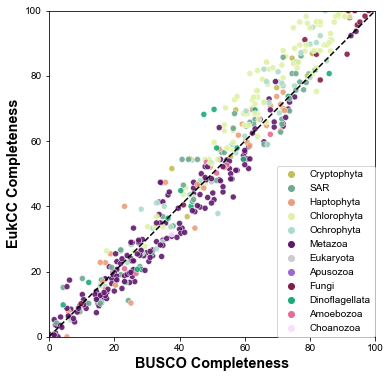

In [8]:
fig,ax = plt.subplots(1, figsize = [6,6])


sns.scatterplot(data = EukMAGDF, x='busco_eukaryota_odb10_completeness', y='eukcc_completeness', palette=cdict, hue='groups', alpha=0.9, lw=0)
ax.legend(loc=[0.7,0])
ax.set_aspect('equal')
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.set_yticks(np.arange(0,101,20))
ax.set_xticks(np.arange(0,101,20))

ax.plot([0,100],[0,100], color='k', ls='--')
ax.set_ylabel('EukCC Completeness', fontsize='x-large', fontweight='bold')
ax.set_xlabel('BUSCO Completeness', fontsize='x-large', fontweight='bold')

fig.savefig('../si-figures/BUSCO-EukCC-comp.pdf',bboxinches='tight')
fig.savefig('../si-figures/BUSCO-EukCC-comp.png',bboxinches='tight')

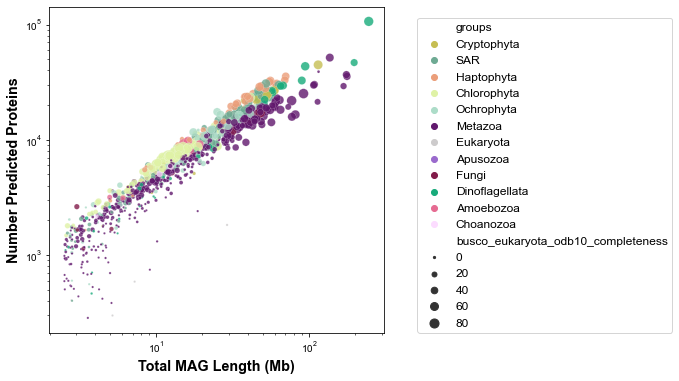

In [9]:
fig,ax = plt.subplots(1, figsize=[6,6])
ax.set_yscale('log')
ax.set_xscale('log')

sns.scatterplot(data = EukMAGDF, x='total_length_Mb', y='num_predicted_proteins', 
                palette=cdict, hue='groups', alpha=0.8, lw=0,
                size='busco_eukaryota_odb10_completeness', sizes=(5,100))
leg = ax.legend(loc=[1.1,0], fontsize='large')
ax.set_xlabel('Total MAG Length (Mb)', fontsize='x-large', fontweight='bold')
ax.set_ylabel('Number Predicted Proteins',  fontsize='x-large', fontweight='bold')
fig.savefig('../si-figures/ALL_MAGS_Num-Prot-Leng.pdf', bbox_inches='tight')
fig.savefig('../si-figures/ALL_MAGS_Num-Prot-Leng.png', bbox_inches='tight')


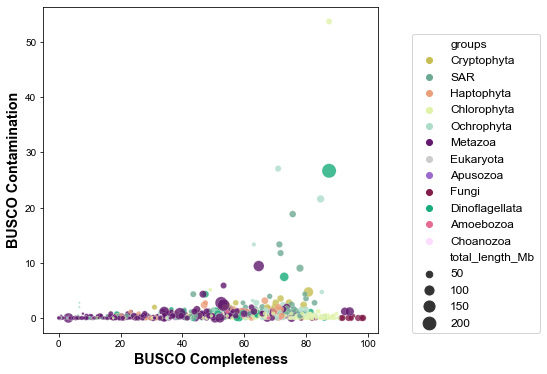

In [10]:
fig,ax = plt.subplots(1, figsize = [6,6])
# ax.set_yscale('symlog')
# ax.set_xscale('log')

sns.scatterplot(data = EukMAGDF, x='busco_eukaryota_odb10_completeness', y='busco_eukaryota_odb10_contamination', 
                palette=cdict, hue='groups', alpha=0.8, lw=1,
                size='total_length_Mb',  sizes=(5,200))
ax.set_xlabel('BUSCO Completeness', fontsize='x-large', fontweight='bold')
ax.set_ylabel('BUSCO Contamination',  fontsize='x-large', fontweight='bold')

ax.legend(loc=[1.1,0], fontsize='large')
fig.savefig('../si-figures/Comp_Cont.pdf', bbox_inches='tight')
fig.savefig('../si-figures/Comp_Cont.png', bbox_inches='tight')

# High Quality MAGs
## >30% BUSCO coverage

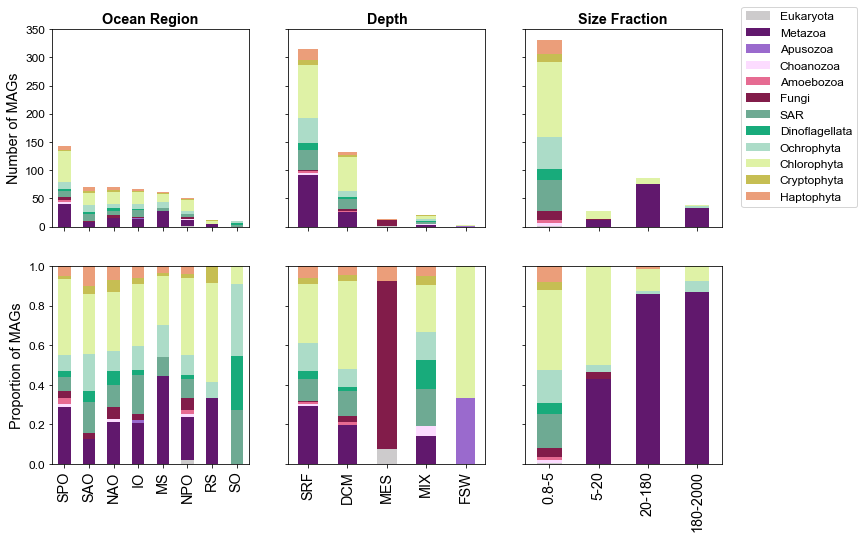

In [11]:
fig, ax = plt.subplots(2,3, figsize = [12,8])
ax=ax.flatten()
depth = pd.DataFrame(EukMAGDF_HQ.groupby(['depth', 'groups']).count()['color']).reset_index()
depth = depth.pivot(index='groups', columns='depth', values='color').fillna(0)
dorder=['SRF',  'DCM', 'MES', 'MIX', 'FSW']
depth.T.loc[dorder,order].plot(kind='bar', stacked=True, color=cdict,ax=ax[1], legend=None)
dn = (depth/depth.sum())
dn.T.loc[dorder,order].plot(kind='bar', stacked=True, color=cdict,ax=ax[4], legend=None)
# ocean region
region = pd.DataFrame(EukMAGDF_HQ.groupby(['ocean_region', 'groups']).count()['color']).reset_index()
region = region.pivot(index='groups', columns='ocean_region', values='color').fillna(0)
rorder = region.sum().sort_values(ascending=False).index
rn = (region/region.sum())
rn.T.loc[rorder,order].plot(kind='bar', stacked=True, color=cdict,ax=ax[3], legend=None)

region.T.loc[rorder,order].plot(kind='bar', stacked=True, color=cdict, legend=None, ax=ax[0])
#size fraction
sf = pd.DataFrame(EukMAGDF_HQ.groupby(['size_fraction', 'groups']).count()['color']).reset_index()
sf = sf.pivot(index='groups', columns='size_fraction', values='color').fillna(0)
sforder = ['0.8-5', '5-20', '20-180','180-2000', ]
sf.T.loc[sforder,order].plot(kind='bar', stacked=True, color=cdict, legend=[1,1], ax=ax[2],)
sn = (sf/sf.sum())
sn.T.loc[sforder, order].plot(kind='bar', stacked=True, color=cdict,ax=ax[5], legend=None)

handles,labels = ax[2].get_legend_handles_labels()
ldict= dict(zip(labels, handles))
olabels = []
ohandles= []

for l in order:
    olabels.append(l)
    ohandles.append(ldict[l])

ax[2].legend(ohandles, olabels, loc=[1.1 ,0.1], fontsize='large')
labels = ['Ocean Region', 'Depth', 'Size Fraction']

for a,l in zip(ax[0:3], labels):
    a.set_ylim(0,350)
    a.set_xlabel('')
    a.set_xticklabels('')
    a.set_title(l, fontweight='bold', size='x-large')
for a in ax[3:]:
    a.set_ylim(0,1)
for i in (1,2,4,5):
    ax[i].set_yticklabels('')
for a in ax:
    a.tick_params(axis='y', 
                labelsize='large')
    a.tick_params(axis='x', 
                labelsize='x-large')
    a.set_xlabel('')
ax[0].set_ylabel('Number of MAGs',fontsize='x-large')
ax[3].set_ylabel('Proportion of MAGs',fontsize='x-large')


fig.savefig('../si-figures/HQ_MAG_distributions.pdf', bbox_inches='tight')
fig.savefig('../si-figures/HQ_MAG_distributions.png', bbox_inches='tight')

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboxinches" which is no longer supported as of 3.3 and will become an error two minor releases later
/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboxinches" which is no longer supported as of 3.3 and will become an error two minor releases later


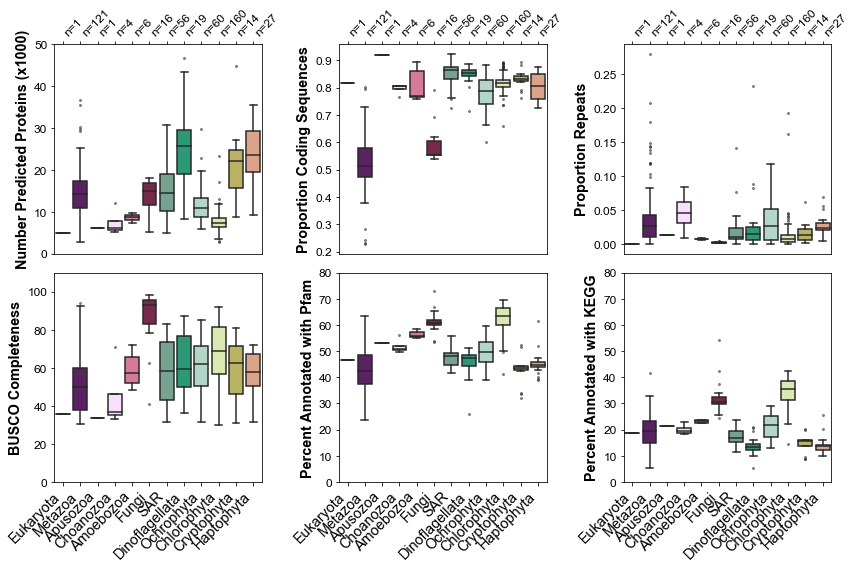

In [12]:
flierprops = {'marker':'o', 'alpha':0.5, 'markersize':2}
fig, ax =plt.subplots(2,3,figsize=[12,8])
ax=ax.flatten()

labels = [ 'Number Predicted Proteins (x1000)', 'Proportion Coding Sequences', 
          'Proportion Repeats', 'BUSCO Completeness', 'Percent Annotated with Pfam','Percent Annotated with KEGG']

sns.boxplot(data = EukMAGDF_HQ, x='groups', y='num_predicted_proteins', palette=cdict,ax=ax[0], order=order, flierprops=flierprops)

sns.boxplot(data = EukMAGDF_HQ, x='groups', y='proportion_coding_sequence_mean', palette=cdict, ax=ax[1], order=order, flierprops=flierprops)

sns.boxplot(data = EukMAGDF_HQ, x='groups', y='proportion_repeat_mean', palette=cdict, ax=ax[2], order=order, flierprops=flierprops)

sns.boxplot(data = EukMAGDF_HQ, x='groups', y='busco_eukaryota_odb10_completeness', palette=cdict,ax=ax[3], order=order, flierprops=flierprops)

sns.boxplot(data = EukMAGDF_HQ, x='groups', y='proportion_proteins_annoated_pfam', palette=cdict,ax=ax[4], order=order, flierprops=flierprops)

sns.boxplot(data = EukMAGDF_HQ, x='groups', y='proportion_proteins_annoated_kegg', palette=cdict,ax=ax[5], order=order, flierprops=flierprops)


count = EukMAGDF_HQ.groupby('groups').count().loc[order, 'eukulele_taxonomy']
count_labels=[]
for i in count.values:
    count_label = 'n={}'.format(i)
    count_labels.append(count_label)

for i in [4,5]:
    ax[i].set_ylim([0,80])
    ax[i].set_xticklabels(labels=order, rotation=45, ha='right')
    ax[i].set_xlabel('')

for i in [2,3]:
    ax[i].set_xticklabels(labels=order, rotation=45, ha='right')
    ax[i].set_xlabel('')

for i in [3]:
    ax[i].set_ylim([0,110])

for i in [0]:
    ax[i].set_ylim([0,50000])
    ax[i].set_yticklabels(range(0,51,10))

for a, l in zip(ax, labels):
    a.set_ylabel(l, fontsize='x-large', fontweight='bold')
    a.tick_params(axis='y', 
                labelsize='large')
    a.tick_params(axis='x', 
                labelsize='x-large')

for i in [0,1,2]:
    ax[i].xaxis.tick_top()
    ax[i].set_xticklabels(count_labels, rotation=45, ha='left', fontsize='large')
    ax[i].set_xlabel('')

plt.tight_layout()


fig.savefig('../si-figures/HQ_MAG_protein_bar_plots.pdf', bboxinches='tight')
fig.savefig('../si-figures/HQ_MAG_protein_bar_plots.png', bboxinches='tight')


In [13]:
EukMAGDF_HQ.groupby('groups').mean()['busco_eukaryota_odb10_completeness']

groups
Amoebozoa         58.888333
Apusozoa          33.730000
Chlorophyta       68.085625
Choanozoa         44.412500
Cryptophyta       59.663571
Dinoflagellata    62.290526
Eukaryota         35.690000
Fungi             86.960625
Haptophyta        57.356296
Metazoa           50.393802
Ochrophyta        60.450667
SAR               57.521071
Name: busco_eukaryota_odb10_completeness, dtype: float64

In [14]:
EukMAGDF_HQ.groupby('groups').mean()['eukcc_completeness']

groups
Amoebozoa         54.612500
Apusozoa          41.380000
Chlorophyta       75.156598
Choanozoa         54.340000
Cryptophyta       66.647000
Dinoflagellata    63.738667
Eukaryota               NaN
Fungi             89.320000
Haptophyta        60.862273
Metazoa           48.239239
Ochrophyta        64.421667
SAR               61.150857
Name: eukcc_completeness, dtype: float64

In [15]:
EukMAGDF_HQ.groupby('groups').std()['proportion_proteins_annoated_pfam']

groups
Amoebozoa         1.364375
Apusozoa               NaN
Chlorophyta       5.057884
Choanozoa         2.847906
Cryptophyta       5.914687
Dinoflagellata    5.706216
Eukaryota              NaN
Fungi             4.660189
Haptophyta        4.126594
Metazoa           7.967745
Ochrophyta        4.932507
SAR               3.512034
Name: proportion_proteins_annoated_pfam, dtype: float64

In [16]:
EukMAGDF_HQ.groupby('groups').std()

,total_length,total_num_contigs,total_length_5kb,total_length_10kb,total_length_50kb,GC_percent,N50,L50,proportion_coding_sequence_mean,proportion_coding_sequence_std,...,proportion_proteins_annoated_pfam,num_unique_pfam,num_proteins_annotated_kegg,proportion_proteins_annoated_kegg,num_unique_kegg,busco_eukaryota_odb10_completeness,busco_eukaryota_odb10_contamination,eukcc_completeness,eukcc_contamination,total_length_Mb
groups,,,,,,,,,,,,,,,,,,,,,
Amoebozoa,1.611455e+06,857.129337,2.964285e+06,2.289817e+06,0.000000e+00,5.650719,1698.689220,391.658227,0.066858,0.012876,...,1.364375,167.120815,218.087521,0.512656,186.870008,9.331828,0.459072,5.166458,1.854562,1.611455
Apusozoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chlorophyta,5.240510e+06,981.983987,5.255093e+06,4.906110e+06,2.227392e+06,7.626632,13499.105502,325.338179,0.029897,0.017567,...,5.057884,479.121323,704.827677,5.171070,440.314069,15.492085,4.255754,17.829326,7.559172,5.240510
Choanozoa,9.728841e+06,1450.659017,7.619281e+06,2.839112e+06,3.485700e+04,4.230386,894.095213,335.627273,0.019261,0.019430,...,2.847906,660.746232,860.018362,2.161117,708.675937,17.819580,0.373397,32.314780,3.896158,9.728841
Cryptophyta,2.381463e+07,3018.159898,2.125389e+07,1.337281e+07,2.809796e+05,3.091545,1800.230113,757.030684,0.034985,0.010268,...,5.914687,580.391626,1064.186665,3.507898,580.564906,16.166909,1.128596,16.483490,11.027917,23.814628
Dinoflagellata,5.601418e+07,11544.036966,3.255653e+07,1.708609e+07,3.539709e+05,3.406203,1149.086762,3738.352047,0.037031,0.014981,...,5.706216,543.924106,2266.903845,3.650927,528.893654,16.030988,6.097903,15.936990,9.003814,56.014177
Eukaryota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fungi,1.299460e+07,1367.789419,1.427168e+07,1.609926e+07,1.753976e+07,4.522476,93428.426971,423.768333,0.067580,0.013767,...,4.660189,542.302729,1052.941386,7.103207,482.436801,15.447075,0.225167,16.807482,1.272346,12.994602
Haptophyta,1.426710e+07,3033.273877,9.608240e+06,4.709239e+06,2.902991e+04,7.420130,970.469753,1054.465431,0.049427,0.008679,...,4.126594,346.101207,737.652931,3.167445,356.639695,11.147193,0.829857,11.105055,6.991545,14.267103


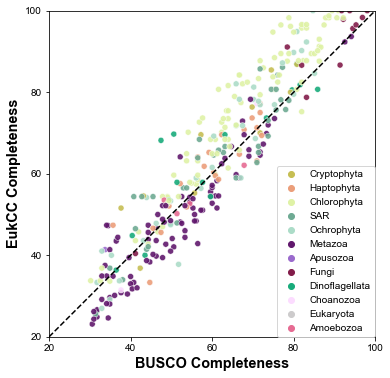

In [17]:
fig,ax = plt.subplots(1, figsize = [6,6])


sns.scatterplot(data = EukMAGDF_HQ, x='busco_eukaryota_odb10_completeness', y='eukcc_completeness', palette=cdict, hue='groups', alpha=0.9, lw=0)
ax.legend(loc=[0.7,0])
ax.set_aspect('equal')
ax.set_xlim(20,100)
ax.set_ylim(20,100)
ax.set_yticks(np.arange(20,101,20))
ax.set_xticks(np.arange(20,101,20))

ax.plot([20,100],[20,100], color='k', ls='--')
ax.set_ylabel('EukCC Completeness', fontsize='x-large', fontweight='bold')
ax.set_xlabel('BUSCO Completeness', fontsize='x-large', fontweight='bold')

fig.savefig('../si-figures/HQ_BUSCO-EukCC-comp.pdf', bbox_inches='tight')
fig.savefig('../si-figures/HQ_BUSCO-EukCC-comp.png', bbox_inches='tight')

# Comparison with environmental parameters + maps

In [9]:
HQ_tpm = tpm_df.merge(EukMAGDF_HQ, left_index=True, right_index=True)
HQ_tpm_grouped = HQ_tpm.groupby('groups').sum()[tpm_df.columns]
HQ_tpm_grouped = HQ_tpm_grouped.T.merge(ena_data, left_index=True, right_index=True)
HQ_tpm_grouped = HQ_tpm_grouped.merge(errnewdf, left_index=True, right_index=True)

In [94]:
# hapto = EukMAGDF[EukMAGDF.groups=='Haptophyta']
# for i in hapto[hapto.eukulele_taxonomy.str.contains('Eukaryota;Hacrobia;Haptophyta;Prymnesiophyceae;Phaeocystales')].index:
#     print(i)
# hapto_plot = pd.DataFrame(HQ_tpm.loc['TOPAZ_SAS3_E008',ena_data.index.intersection(HQ_tpm.columns)]).merge(ena_data, 
#                                                                             left_index=True, right_index=True)
# hapto_plot = hapto_plot.merge(errnewdf, left_index=True, right_index=True)
# hapto_plot
# depth='SRF'
# sf = ['0.8-5.00','5-20.00', '20-180.00','180-2000.00', ]
# fig = plt.figure(figsize=(18, 18))
# gs = fig.add_gridspec(1, 4)
# scale=1e-2
# for i, s in enumerate(sf):
#     sHQ_tpm_grouped = hapto_plot[(hapto_plot['sf']==s) & (hapto_plot['depth']==depth)] 
#     sHQ_tpm_grouped['TOPAZ_SAS3_E008']=sHQ_tpm_grouped['TOPAZ_SAS3_E008'].astype(float)
#     ax = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())
#     ax.add_feature(cfeature.LAND, color = 'gray')
#     ax.scatter(x=sHQ_tpm_grouped['Longitude'], y=sHQ_tpm_grouped['Latitude'], s=sHQ_tpm_grouped['TOPAZ_SAS3_E008']*scale)
# #     ax.set_title(s, fontsize='x-large', fontweight='bold')
# #     ax.set_extent([-180, 100, -80, 65], crs=ccrs.PlateCarree())
# # legend_sizes = [1e4,5e4, 1e5,5e5]
# # for i in legend_sizes:
# #     ax.scatter(x=0, y=0, s=i*scale, label='{:1.0e}'.format(i), color='red', lw=0)
# ax.legend(scatterpoints=1, loc=[1.2,0], ncol=1)
# # plt.savefig('../si-figures/SRF-summed-HQ-taxonomy.pdf')

In [19]:
order = ['Eukaryota',  'Metazoa', 'Apusozoa','Choanozoa','Amoebozoa','Fungi','SAR', 'Dinoflagellata','Ochrophyta','Chlorophyta', 'Cryptophyta',  'Haptophyta', ]

cols = ['Eukaryota',  'Metazoa', 'Apusozoa','Choanozoa','Amoebozoa','Fungi','SAR', 'Dinoflagellata','Ochrophyta','Chlorophyta', 'Cryptophyta',  'Haptophyta', 
 'Depth ref [m] (in the selected environmental...)',
 'Sal (in the selected environmental...)',
 'Tpot [°C] (in the selected environmental...)',
 'Sigma-theta [kg/m**3] (in the selected environmental...)',
 'O2 [µmol/kg] (in the selected environmental...)',
 '[NO3]- [µmol/l] (in the selected environmental...)',
 '[NO2]- [µmol/l] (in the selected environmental...)',
 '[PO4]3- [µmol/l] (in the selected environmental...)',
 '[NO3]- + [NO2]- [µmol/l] (in the selected environmental...)',
 'Si(OH)4 [µmol/l] (in the selected environmental...)',
 'Chl a [mg/m**3] (in the selected environmental...)',
 'bbp470 [1/m] (in the selected environmental...)',
 'fCDOM [ppb (QSE)] (in the selected environmental...)',
 'bacp660 [1/m] (in the selected environmental...)',
 'fCDOM [ppb (QSE)] (at the sampling location, exp...)',
 'PAR day [mol quanta/m**2/day] (for a period of 8 days around...)',
 'NPP C [mg/m**2/day] (for a period of 8 days around...)',
 'MLD [m] (in the selected environmental...)',
 'D chl m [m] (in the selected environmental...)',
 'Depth max Brunt Väisälä freq [m] (in the selected environmental...)',
 'Depth max O2 [m] (in the selected environmental...)',
 'Depth nitracline [m] (in the selected environmental...)',
 'SSD [min] (day length)',
 "u [cm/s] (Calculated (d'Ovidio et al. 2...)",
 "v [cm/s] (Calculated (d'Ovidio et al. 2...)",
 'OW (indicates the presence of an ...)',
 'MLE [1/day] (indicates the presence of a t...)',
 "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)",
 'RT [days] (of the water mass. Values>30 ...)',
]
tax_clist = []
for i in order:
    tax_clist.append(cdict[i]) 

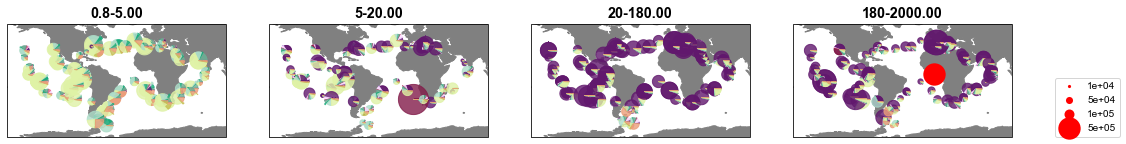

In [20]:
depth='SRF'
sf = ['0.8-5.00','5-20.00', '20-180.00','180-2000.00', ]
fig = plt.figure(figsize=(18, 18))
gs = fig.add_gridspec(1, 4)
scale=10**-3
for i, s in enumerate(sf):
    sHQ_tpm_grouped = HQ_tpm_grouped[(HQ_tpm_grouped['sf']==s) & (HQ_tpm_grouped['depth']==depth)]
    ax = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, color = 'gray')
    for i in sHQ_tpm_grouped.index:
        proportion=[]
        for o in order:
            proportion.append(sHQ_tpm_grouped.loc[i,o])
        draw_pie(proportion, 
                 xpos =sHQ_tpm_grouped.loc[i,'Longitude'], ypos=sHQ_tpm_grouped.loc[i,'Latitude'],
                 size=sum(proportion)*scale, cartopy=True, ax=ax, 
                 colors=tax_clist)
    ax.set_title(s, fontsize='x-large', fontweight='bold')
    ax.set_extent([-180, 100, -80, 65], crs=ccrs.PlateCarree())
legend_sizes = [1e4,5e4, 1e5,5e5]
for i in legend_sizes:
    ax.scatter(x=0, y=0, s=i*scale, label='{:1.0e}'.format(i), color='red', lw=0)
ax.legend(scatterpoints=1, loc=[1.2,0], ncol=1)
plt.savefig('../si-figures/SRF-summed-HQ-taxonomy.pdf')

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


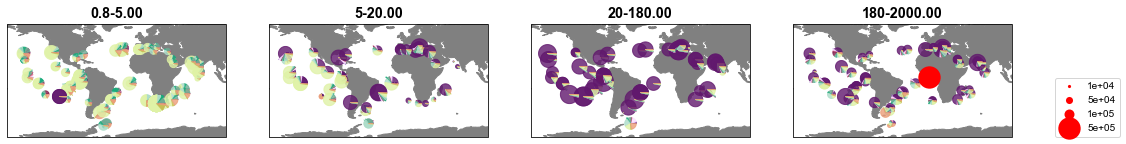

In [21]:
depth='DCM'
sf = ['0.8-5.00','5-20.00', '20-180.00','180-2000.00', ]
fig = plt.figure(figsize=(18, 18))
gs = fig.add_gridspec(1, 4)
scale=10**-3
for i, s in enumerate(sf):
    sHQ_tpm_grouped = HQ_tpm_grouped[(HQ_tpm_grouped['sf']==s) & (HQ_tpm_grouped['depth']==depth)]
    ax = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, color = 'gray')
    for i in sHQ_tpm_grouped.index:
        proportion=[]
        for o in order:
            proportion.append(sHQ_tpm_grouped.loc[i,o])
        draw_pie(proportion, 
                 xpos =sHQ_tpm_grouped.loc[i,'Longitude'], ypos=sHQ_tpm_grouped.loc[i,'Latitude'],
                 size=sum(proportion)*scale, cartopy=True, ax=ax, 
                 colors=tax_clist)
    ax.set_title(s, fontsize='x-large', fontweight='bold')
    ax.set_extent([-180, 110, -80, 70], crs=ccrs.PlateCarree())
legend_sizes = [1e4,5e4, 1e5,5e5]
for i in legend_sizes:
    ax.scatter(x=0, y=0, s=i*scale, label='{:1.0e}'.format(i), color='red', lw=0)
ax.legend(scatterpoints=1, loc=[1.2,0], ncol=1)
plt.savefig('../si-figures/DCM-summed-HQ-taxonomy.pdf')

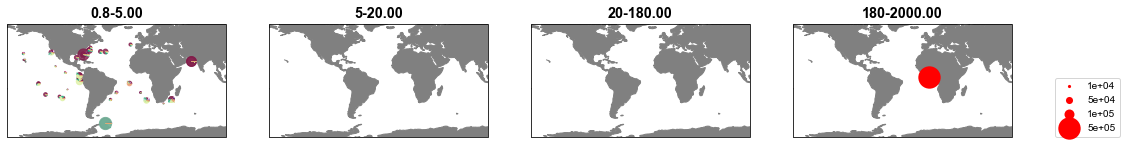

In [22]:
depth='MES'
sf = ['0.8-5.00','5-20.00', '20-180.00','180-2000.00', ]
fig = plt.figure(figsize=(18, 18))
gs = fig.add_gridspec(1, 4)
scale=10**-3
for i, s in enumerate(sf):
    sHQ_tpm_grouped = HQ_tpm_grouped[(HQ_tpm_grouped['sf']==s) & (HQ_tpm_grouped['depth']==depth)]
    ax = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, color = 'gray')
    for i in sHQ_tpm_grouped.index:
        proportion=[]
        for o in order:
            proportion.append(sHQ_tpm_grouped.loc[i,o])
        draw_pie(proportion, 
                 xpos =sHQ_tpm_grouped.loc[i,'Longitude'], ypos=sHQ_tpm_grouped.loc[i,'Latitude'],
                 size=sum(proportion)*scale, cartopy=True, ax=ax, 
                 colors=tax_clist)
    ax.set_title(s, fontsize='x-large', fontweight='bold')
    ax.set_extent([-180, 110, -80, 70], crs=ccrs.PlateCarree())
legend_sizes = [1e4,5e4, 1e5,5e5]
for i in legend_sizes:
    ax.scatter(x=0, y=0, s=i*scale, label='{:1.0e}'.format(i), color='red', lw=0)
ax.legend(scatterpoints=1, loc=[1.2,0], ncol=1)
plt.savefig('../si-figures/MES-summed-HQ-taxonomy.pdf')

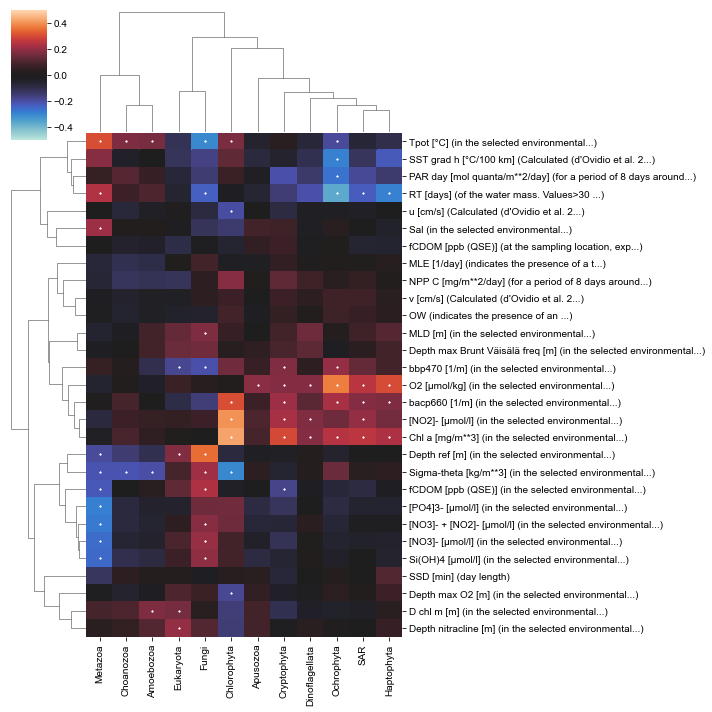

In [23]:
out_rho, out_pval, out_bonfe = calc_rho_pval(HQ_tpm_grouped[cols])
ax = cluster_map_bonfe(out_rho.fillna(0)[order].drop(order), out_bonfe.fillna(1)[order].drop(order), 
                  figname='../si-figures/mag-group-correlation.pdf', cutoff=0.01, vmin=-.5, vmax=0.5)


In [24]:
HQ_tpm_grouped[ (HQ_tpm_grouped['depth']=='MES')][order].sum(axis=1).std()

34449.79142297652

In [25]:
HQ_tpm_grouped[ (HQ_tpm_grouped['depth']=='SRF')][order].sum(axis=1).std()

104094.94519179304

In [26]:
HQ_tpm_grouped[ (HQ_tpm_grouped['depth']=='DCM')][order].sum(axis=1).std()

85031.0455548849

In [27]:
import glob 
map_dict = {}
path = '/vortexfs1/omics/alexander/halexander/2020-tara-mag-abund/2020-output/'
for file in glob.glob(os.path.join(path, '*tab')):
    mapping = 100 - pd.read_csv(file,sep='\t').iloc[0,-1]
    name = os.path.basename(file).strip('.coverm.abundance.tab')
    map_dict[name]=mapping

In [28]:
test = tpm_df.merge(EukMAGDF_HQ, left_index=True, right_index=True).T
test = test.loc[tpm_df.columns]

In [29]:
all_mag_mereged = test.merge(ena_data, left_index=True, right_index=True)
all_mag_mereged = all_mag_mereged.merge(errnewdf, left_index=True, right_index=True)

In [30]:
cols = [ 
 'Depth ref [m] (in the selected environmental...)',
 'Sal (in the selected environmental...)',
 'Tpot [°C] (in the selected environmental...)',
 'Sigma-theta [kg/m**3] (in the selected environmental...)',
 'O2 [µmol/kg] (in the selected environmental...)',
 '[NO3]- [µmol/l] (in the selected environmental...)',
 '[NO2]- [µmol/l] (in the selected environmental...)',
 '[PO4]3- [µmol/l] (in the selected environmental...)',
 '[NO3]- + [NO2]- [µmol/l] (in the selected environmental...)',
 'Si(OH)4 [µmol/l] (in the selected environmental...)',
 'Chl a [mg/m**3] (in the selected environmental...)',
 'bbp470 [1/m] (in the selected environmental...)',
 'fCDOM [ppb (QSE)] (in the selected environmental...)',
 'bacp660 [1/m] (in the selected environmental...)',
 'fCDOM [ppb (QSE)] (at the sampling location, exp...)',
 'PAR day [mol quanta/m**2/day] (for a period of 8 days around...)',
 'NPP C [mg/m**2/day] (for a period of 8 days around...)',
 'MLD [m] (in the selected environmental...)',
 'D chl m [m] (in the selected environmental...)',
 'Depth max Brunt Väisälä freq [m] (in the selected environmental...)',
 'Depth max O2 [m] (in the selected environmental...)',
 'Depth nitracline [m] (in the selected environmental...)',
 'SSD [min] (day length)',
 "u [cm/s] (Calculated (d'Ovidio et al. 2...)",
 "v [cm/s] (Calculated (d'Ovidio et al. 2...)",
 'OW (indicates the presence of an ...)',
 'MLE [1/day] (indicates the presence of a t...)',
 "SST grad h [°C/100 km] (Calculated (d'Ovidio et al. 2...)",
 'RT [days] (of the water mass. Values>30 ...)',
]

for i in test.columns:
    cols.append(i)

all_mag_mereged = all_mag_mereged[cols]

In [31]:
out_rho, out_pval, out_bonfe = calc_rho_pval(all_mag_mereged[cols])


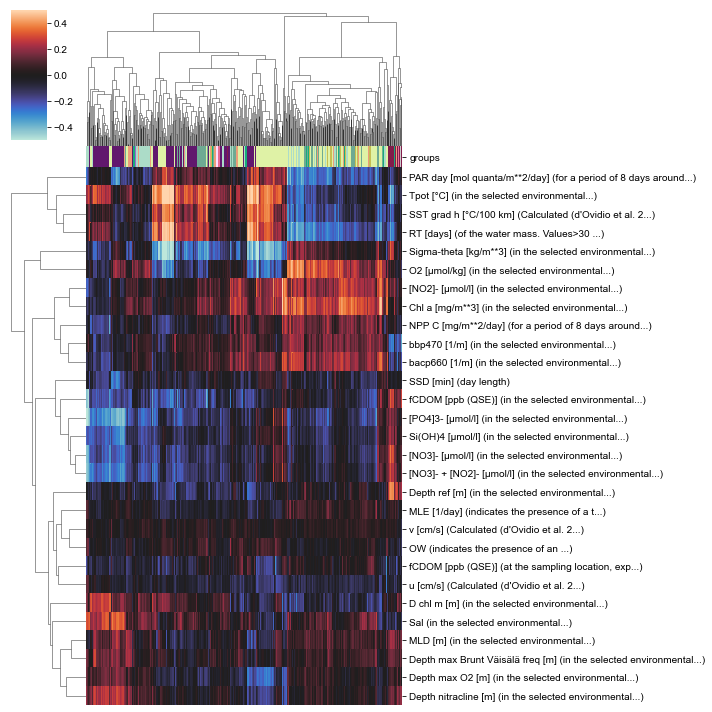

In [32]:
sns.clustermap(out_rho.fillna(0)[test.columns].drop(test.columns),
               col_colors=EukMAGDF_HQ.groups.map(cdict), 
               vmin=-0.5, vmax=0.5,xticklabels=False, cmap='icefire')
plt.savefig('../si-figures/individual-mag-group-correlation.pdf')


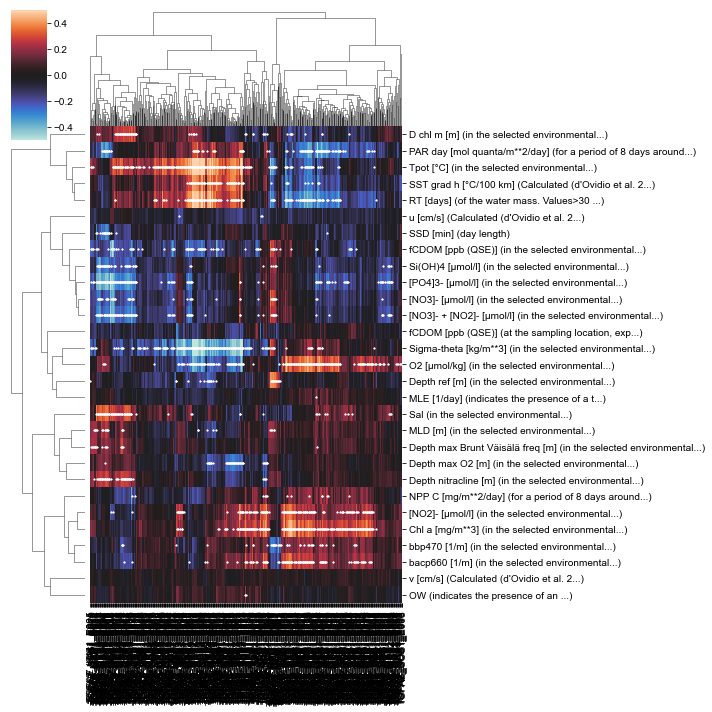

In [33]:
ax = cluster_map_bonfe(out_rho.fillna(0)[test.columns].drop(test.columns), out_bonfe.fillna(1)[test.columns].drop(test.columns), 
                  figname='../si-figures/test.pdf', cutoff=0.001, vmin=-.5, vmax=0.5, xticklabel=False)




In [34]:
out_rho.fillna(0)[test.columns].drop(test.columns).to_csv('../tables/final/mag-spearman-env.csv')

In [35]:
out_bonfe.fillna(0)[test.columns].drop(test.columns).to_csv('../tables/final/mag-bonfe-env.csv')

In [36]:
out_bonfe

level_0,Chl a [mg/m**3] (in the selected environmental...),D chl m [m] (in the selected environmental...),Depth max Brunt Väisälä freq [m] (in the selected environmental...),Depth max O2 [m] (in the selected environmental...),Depth nitracline [m] (in the selected environmental...),Depth ref [m] (in the selected environmental...),MLD [m] (in the selected environmental...),MLE [1/day] (indicates the presence of a t...),NPP C [mg/m**2/day] (for a period of 8 days around...),O2 [µmol/kg] (in the selected environmental...),...,[NO2]- [µmol/l] (in the selected environmental...),[NO3]- + [NO2]- [µmol/l] (in the selected environmental...),[NO3]- [µmol/l] (in the selected environmental...),[PO4]3- [µmol/l] (in the selected environmental...),bacp660 [1/m] (in the selected environmental...),bbp470 [1/m] (in the selected environmental...),"fCDOM [ppb (QSE)] (at the sampling location, exp...)",fCDOM [ppb (QSE)] (in the selected environmental...),u [cm/s] (Calculated (d'Ovidio et al. 2...),v [cm/s] (Calculated (d'Ovidio et al. 2...)
level_1,,,,,,,,,,,,,,,,,,,,,
Chl a [mg/m**3] (in the selected environmental...),0,9.27138e-35,0.0778304,0.226296,4.7079e-12,1,1,1,2.65773e-13,8.82289e-08,...,9.42713e-78,1.19044e-10,1,5.7909e-08,1.26129e-82,1.76476e-38,1,1.43812e-05,0.241733,1
D chl m [m] (in the selected environmental...),9.27138e-35,0,1,4.73548e-29,1.17843e-32,1.5838e-06,0.011447,1,5.64555e-78,0.00459393,...,1.92881e-40,5.17843e-17,0.186147,1.38314e-09,2.97475e-80,6.47168e-42,1.58866e-05,1,0.297141,1
Depth max Brunt Väisälä freq [m] (in the selected environmental...),0.0778304,1,0,3.14079e-08,3.08255e-69,1,1.87197e-124,1,1,1,...,1,1,1,0.22283,2.60838e-09,1.69498e-25,1,2.6141e-05,1,1
Depth max O2 [m] (in the selected environmental...),0.226296,4.73548e-29,3.14079e-08,0,6.67547e-51,7.65129e-05,1.27959e-14,2.68396e-28,0.736714,5.70569e-06,...,1.48309e-11,1.61898e-06,1,2.67752e-11,1.05418e-10,0.0011923,1,1,1,1
Depth nitracline [m] (in the selected environmental...),4.7079e-12,1.17843e-32,3.08255e-69,6.67547e-51,0,0.000162653,3.32879e-48,1,4.51331e-06,1,...,0.0945926,0.000299711,1,4.08483e-17,2.47417e-41,1.26945e-55,1,1,0.0406746,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bbp470 [1/m] (in the selected environmental...),1.76476e-38,6.47168e-42,1.69498e-25,0.0011923,1.26945e-55,1.89718e-14,5.85699e-30,1,1.70407e-37,6.66316e-16,...,0.00105918,1,1,1,2.24483e-145,0,1,1,0.00118746,1
"fCDOM [ppb (QSE)] (at the sampling location, exp...)",1,1.58866e-05,1,1,1,1,1,1,5.20205e-08,1,...,0.081724,1,1,1,1,1,0,1,1,1
fCDOM [ppb (QSE)] (in the selected environmental...),1.43812e-05,1,2.6141e-05,1,1,5.19406e-09,1,1,1,1,...,3.48519e-12,7.40492e-56,1.27584e-47,2.42081e-46,1,1,1,0,1,1


In [95]:
# pangea[[ '[NO3]- [µmol/l] (in the selected environmental...)',
#  '[NO2]- [µmol/l] (in the selected environmental...)', '[NO3]- + [NO2]- [µmol/l] (in the selected environmental...)',
# ]].dropna().plot(kind='scatter', x= '[NO2]- [µmol/l] (in the selected environmental...)', 
#                  y='[NO3]- + [NO2]- [µmol/l] (in the selected environmental...)')

In [96]:
# EukMAGDF_HQ.groupby('groups').total_length.mean()

In [39]:
# EukMAGDF_HQ.groupby('groups').mean().busco_eukaryota_odb10_completeness

groups
Amoebozoa         58.888333
Apusozoa          33.730000
Chlorophyta       68.085625
Choanozoa         44.412500
Cryptophyta       59.663571
Dinoflagellata    62.290526
Eukaryota         35.690000
Fungi             86.960625
Haptophyta        57.356296
Metazoa           50.393802
Ochrophyta        60.450667
SAR               57.521071
Name: busco_eukaryota_odb10_completeness, dtype: float64